# Classification of quantum states with high dimensional entanglement 

In [1]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
from scipy.signal import savgol_filter
import time

In [2]:
from o_utils import ora # classifier utilities
from o_plot import opl # utilities for result plot
from c_utils import cut # circuit building utilities

## Set up the simulator and layout for 5 qubits

In [3]:
simulator = Aer.get_backend('qasm_simulator')

In [4]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [5]:
program_name="QAD" # in hommage of the Qiskit advocates
Flag_char = "DS" # this for a mix of GHZ Psi+ and W Phi+ separable states
if len(Flag_char) >= 2:
    unique_char = "M"
else:
    unique_char = Flag_char

In [6]:
# These dictionaries for the devices used in the study
fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,
                "ibmqx2": 0.627392, 'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ideal_device': 1.0}
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0, 
          "ibmqx2": 8.0, 'ibmq_santiago': 32.0, 'ibmq_vigo': 16.0, 'ideal_device': np.inf}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor',  'ideal_device': "Ide"}

In [7]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [8]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device of course
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [9]:
# tail of the file  names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

QAD_Ide
QAD_Ide_M000


In [10]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) # 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [11]:
len(meas_calibs)

32

In [12]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]

## Create the quantum states


In [13]:
# version 20 circuits for demonstration
# (in the version run on real devices: two batches of 10 circuits, "shallow" and "deep")

# these circuits limited to state creation are ready to be saved 
# for  ultimately building circuits adapted to noisy simulator and real devices
# as option, these circuits will include a row of id gates between creation and measurements

circ_ori = []
for state_1 in ("W", "GHZ"):
    if state_1 == "GHZ":
        state_2 = "Psi+"
    if state_1 == "W":
        state_2 = "Phi+"
    for perm in q_perm:
            mycircuit = QuantumCircuit(used_qubits, used_qubits)                                   
            mycircuit = cut.circuit_builder(mycircuit, perm, state_1,state_2)
            circ_ori.append(mycircuit)

In [14]:
# add measurement section to the circuit set newly created:
nb_states = len(circ_ori)
circ_ideal = copy.deepcopy(circ_ori)
for i_state in range(nb_states):
    cut.add_barrier_and_measure(circ_ideal[i_state],qubit_list)

## Obtain result distributions on  noise free simulator

In [15]:
# execute on noise free simulator  
s_sim = 12000
job_simul = execute(circ_ideal, backend=simulator, shots=s_sim)
tot_results_simul = job_simul.result()

In [16]:
# establish a dictionary of count results on noise free simulator:
# (this step is only useful if ram storage is performed)
void_counts = dict(zip(label_list, np.zeros(2**used_qubits, dtype=int)))
tot_results_sim_dic = {}
ideal_dic = {}
for i_state in range(nb_states):
    counts_simul = copy.deepcopy(void_counts)
    counts_simul.update(tot_results_simul.get_counts(i_state))
    ideal_dic[str(i_state)]=counts_simul

Example of circuit for separable state $W\otimes\Phi^+ $:

Ide circuit # 5


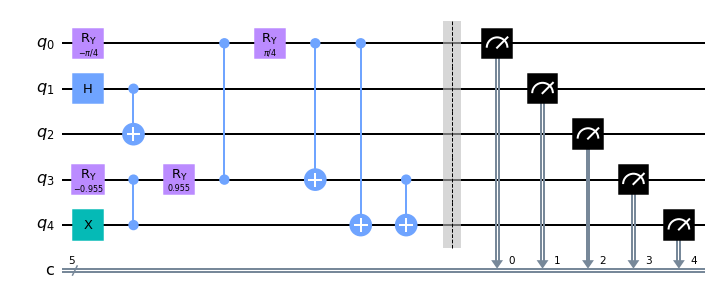

In [17]:
i_state_test = 5
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 5


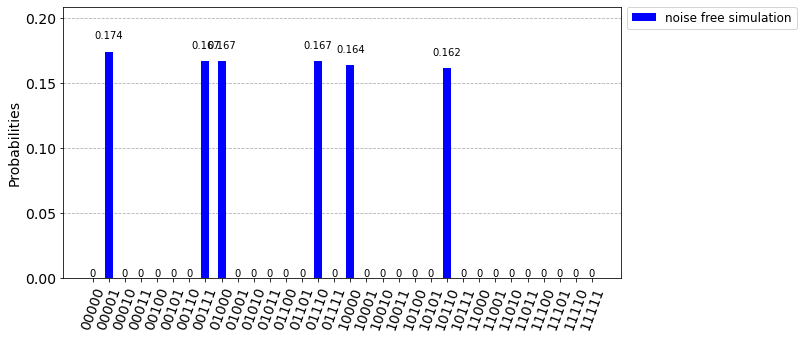

In [18]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

Example of circuit for separable state $GHZ\otimes\Psi^+ $:

Ide circuit # 19


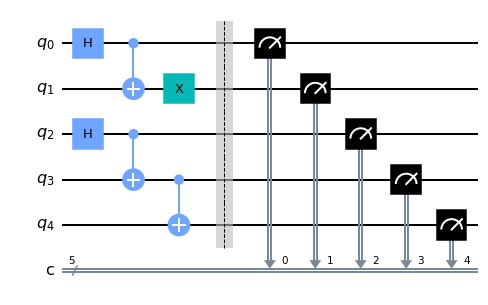

In [19]:
i_state_test = 19
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 19


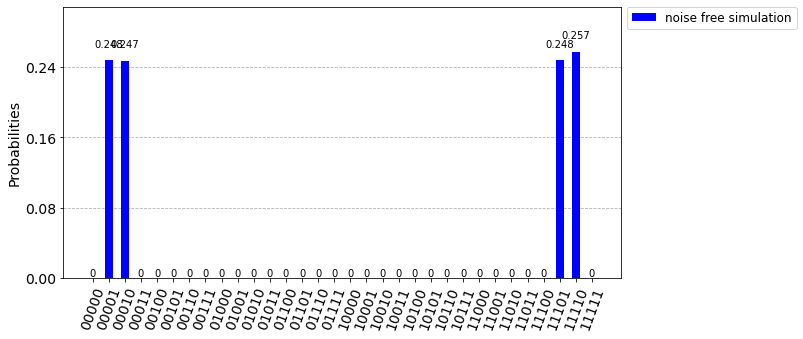

In [20]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [21]:
PD_ideal =  np.ndarray((nb_states,nb_labels))
for i_state in range(nb_states):
    PD_ideal[i_state, :] = list(ideal_dic[str(i_state)].values())
# now a little trick to get the ideal values from the simulator approximated values
with np.errstate(divide='ignore'): # ignore the divide by zero warning
    PD_ideal = 1/np.round(s_sim/(PD_ideal))
# have a look at the matrix head and tail:
print("first and last state probability distributions:")
print(np.round(np.vstack((PD_ideal[0:1,:],PD_ideal[-1:,:])),4)) 

first and last state probability distributions:
[[0.     0.1667 0.1667 0.     0.1667 0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.1667 0.1667 0.     0.1667 0.
  0.     0.    ]
 [0.     0.25   0.25   0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.25
  0.25   0.    ]]


## Monte Carlo simulation for the ideal device

In [22]:
# common code for the different options
def add_single_dic(target_data_list):
    start_time = time.time()                
           
    print("started",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name)
    
    # added for D,S,M choice. Mainstream : mixed set of 20 states
    first = 0
    last = nb_states
    if unique_char == "D":
        last = int(nb_states/2)
    elif unique_char == "S":
        first = int(nb_states/2)
    
    # get the classifier error curve in function of the number of shot and the "safe shot number" 
    error_curve, safe_rate, ernb = ora.provide_error_curve(PD_model=model_dic[model_name][first:last,:],
                                                   PD_test=PD_test[first:last,:],
                                                   trials=trials,
                                                   window=window,
                                                   epsilon=epsilon,
                                                   max_shots=max_shots,
                                                   pol=pol,
                                                   verbosality=verbosality)

    tail = savgol_filter(ernb, window, pol, axis=0)
    len_curve = len(error_curve)
    safe_shot_nb = len_curve - int((window-1)/2) # OK
    print('safe_shot_nb',safe_shot_nb, 'safe_rate',safe_rate, "nb trials:",trials)
    err_rates = tail[int((window-1)/2),:]/trials 
    err_rate_max = np.max(err_rates)
    err_rate_min = np.min(err_rates)
    r=4
    print("savgol interpolated error rate mean:", np.round(np.mean(err_rates),r),
          "min:", np.round(err_rate_min,r),
          "max:", np.round(err_rate_max,r), "for",
          [ien for ien, jen in enumerate(err_rates) if jen == err_rate_max])
    end_time = time.time()
    
    #save the data in a list of dictionaries :
    single_dic={"project":mitig_name,
                "id_gates":id_gates,
                "mitigation":mit_str,
                "model":model_name,
                "metric":o_metric, "device":project_device,                              
                "curve_length":len_curve, 
                "shots": safe_shot_nb,
                "shots_rate": safe_rate,                                                                                    
                "error_curve":error_curve,
                "trials":trials,"window":window,
                "epsilon":epsilon,"SG_pol": pol,                         
                "computation_time":end_time-start_time,
                "time_completed":time.strftime('%d/%m/%Y %H:%M:%S'),
                "trials":trials,
                "QV": QV_dic[project_device],
                "fidelity": fidelity_dic[project_device],
                "error_nb":ernb}
    target_data_list.append(single_dic)
    
    print("completed",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name,"\n")

In [23]:
# here will be appended the data we want for the curve plot 
ideal_data_list=[]

###  you may want to skip this cell and get stored curves by running the next cell

In [ ]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary (readme file):
trials=10000
window=5 # shorter window than for the real device counts
epsilon = .001
min_shots = 5
max_shots = 100
pol=2

subset = None # variable not used here
verbosality = 5 # printing step for intermediate results when increasing the experiment shot number 

PD_test = PD_ideal
mitigation_dic =  {"Na": None} 
o_metrics_desired = ['jensenshannon', 'sqeuclidean']
model_dic = {"ideal_sim": PD_ideal}
for mit_str, mitigation in mitigation_dic.items():
    if mitigation != None: # thus only for counts on real device
        PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    for o_metric in o_metrics_desired:           
            for model_name in model_dic.keys():
                add_single_dic(ideal_data_list)                

In [25]:
# get the stored results of the Monte Carlo simulation in case you skipped the previous step
if len(ideal_data_list) == 0:
    file_name = "ideal_device_data_list_"+project_name+'.json'
    f = open(file_name)
    ideal_data_list = json.load(f)

<Figure size 432x288 with 0 Axes>

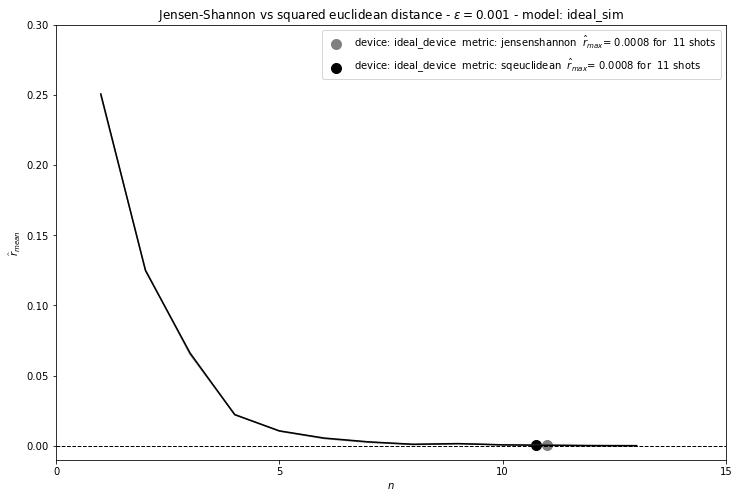

In [26]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors the unsmoothed values 
opl.plot_curves(ideal_data_list,np.array([0,1]),
            "Jensen-Shannon vs squared euclidean distance - $\epsilon=0.001$" , 
             ["model"], ["device","metric"],
             right_xlimit = 15, bottom_ylimit = -0.01, top_ylimit = 0.3)

# Real device section

In [27]:
from qiskit import IBMQ

In [28]:
IBMQ.load_account()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [29]:
provider = IBMQ.get_provider(hub='ibm-q')

In [30]:
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]


In [31]:
project_device = 'ibmq_vigo'# you may choice here a different backend
device_name = dev_dic[project_device]
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

QAD_Vig
QAD_Vig_M000


In [32]:
# determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

### Transpile the basic circuits for running on real device
In this demo, these are not the circuits which were actually run on real devices (not the same transpiler seed).
The optimization level is set to 2 instead of 3 in real experiments, for speed and also because at this moment there is a transpiler error occuring for ibmqx2: 'Maximum iteration reached. max_iteration=1000' 

In [33]:
# transpile
verbose = True  
summary_dic = {}
seed_transpiler_list = list(range(nb_states))

start_time = time.strftime('%d/%m/%Y %H:%M:%S')    
print("Start at DMY: ",start_time)
for i_state in list(range(nb_states)):    
    # prepare circuit to be transpiled
    circuit = copy.deepcopy(circ_ori[i_state])
    if id_gates > 0:
        circuit.barrier()
        for id_gates_index in range(id_gates):
            for index, value in enumerate(qubit_list):
                circuit.id(value)
    
    cut.add_barrier_and_measure(circuit, qubit_list)
    
    summary = []        
    depth_list = [] 

    Q_state_opt_new = transpile(circuit, backend=device,
                        coupling_map = coupling_map,
                        seed_transpiler=seed_transpiler_list[i_state],
                        optimization_level=2,
                        initial_layout=qubit_list)

    summary_dic[i_state] = {"depth": Q_state_opt_new.depth(),
                            'circuit':Q_state_opt_new}
    
    if verbose:
        print("circuit %2i" % i_state,"length",summary_dic[i_state]["depth"],
              "DMY: ",time.strftime('%d/%m/%Y %H:%M:%S')) 

end_time = time.strftime('%d/%m/%Y %H:%M:%S')  
print("Completed at DMY: ",end_time)    

Start at DMY:  20/12/2020 16:40:15
circuit  0 length 54 DMY:  20/12/2020 16:40:15
circuit  1 length 67 DMY:  20/12/2020 16:40:15
circuit  2 length 59 DMY:  20/12/2020 16:40:15
circuit  3 length 57 DMY:  20/12/2020 16:40:15
circuit  4 length 69 DMY:  20/12/2020 16:40:16
circuit  5 length 56 DMY:  20/12/2020 16:40:16
circuit  6 length 54 DMY:  20/12/2020 16:40:16
circuit  7 length 60 DMY:  20/12/2020 16:40:16
circuit  8 length 53 DMY:  20/12/2020 16:40:16
circuit  9 length 58 DMY:  20/12/2020 16:40:16
circuit 10 length 14 DMY:  20/12/2020 16:40:16
circuit 11 length 20 DMY:  20/12/2020 16:40:16
circuit 12 length 18 DMY:  20/12/2020 16:40:16
circuit 13 length 23 DMY:  20/12/2020 16:40:16
circuit 14 length 24 DMY:  20/12/2020 16:40:16
circuit 15 length 18 DMY:  20/12/2020 16:40:16
circuit 16 length 21 DMY:  20/12/2020 16:40:16
circuit 17 length 21 DMY:  20/12/2020 16:40:16
circuit 18 length 24 DMY:  20/12/2020 16:40:16
circuit 19 length 21 DMY:  20/12/2020 16:40:16
Completed at DMY:  20/12/

In [34]:
i_state_test = 0
print(project_device, "circuit #",i_state_test,
      "circuit length:", summary_dic[i_state_test]['depth'])

ibmq_vigo circuit # 0 circuit length: 54


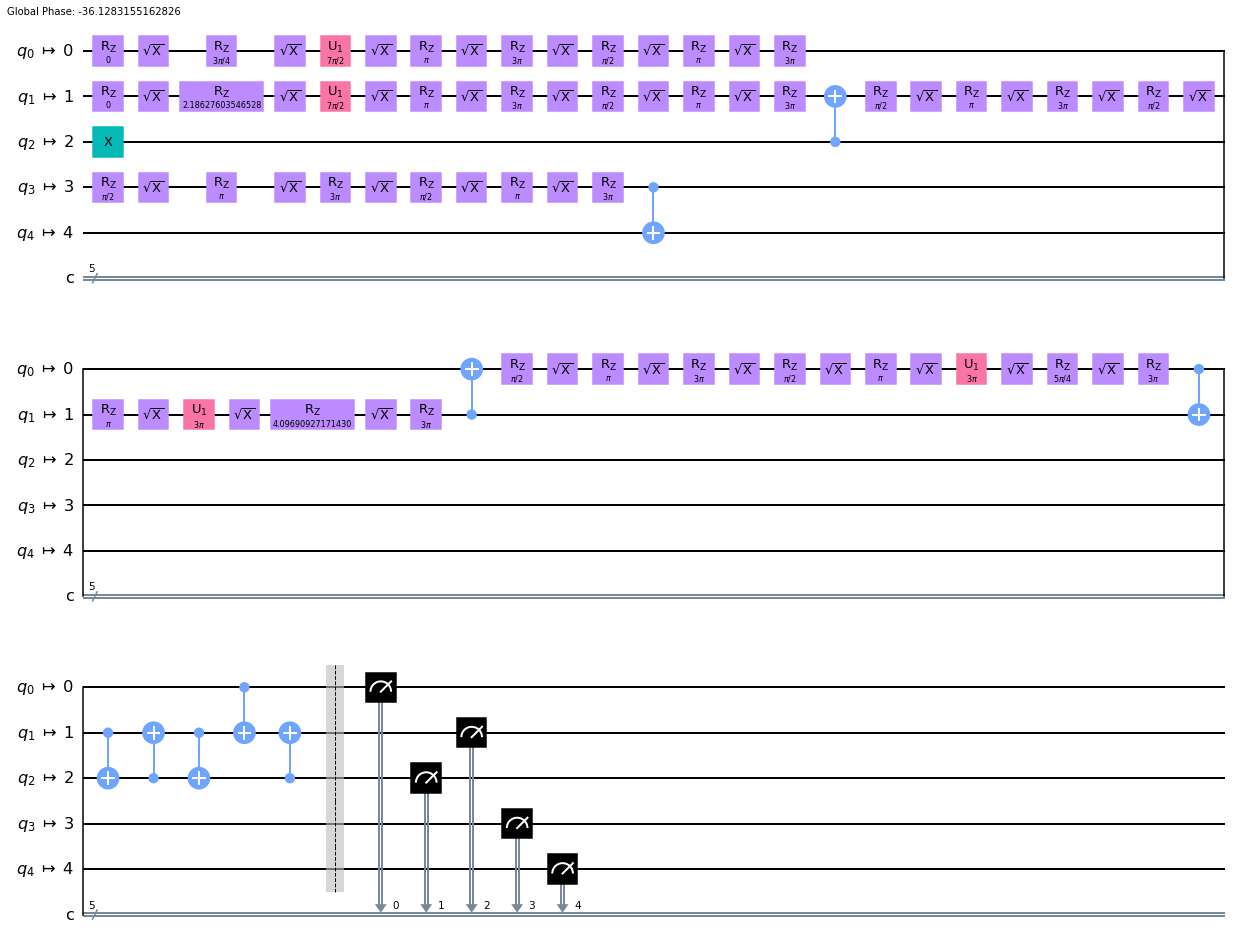

In [35]:
# you may want to skip this if large nb of id gates before measurement
summary_dic[i_state_test]['circuit'].draw(output='mpl')

ibmq_vigo circuit # 0 on noise free simulator


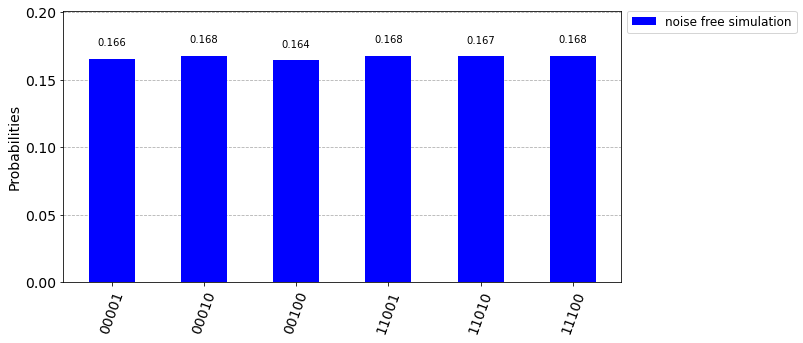

In [36]:
job_simul = execute(summary_dic[i_state_test]['circuit'], backend=simulator, shots=s_sim)
print(project_device, "circuit #",i_state_test, "on noise free simulator")
plot_histogram(job_simul.result().get_counts(),
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

### Load  the transpiled circuits that were actually run 

In [37]:
def json_dic_loader(dic_name):
    f = open(dic_name+"_"+sub_project_name+'.json')
    return json.load(f)  

In [38]:
# changing keys of dictionary for merging:    
def key_change(ini_dict, i_subset):
    ini_list = []
    len_ini = len(ini_dict)
    for i in range(len_ini):
        ini_list.append(str(i+i_subset*len_ini))
    return dict(zip(ini_list, list(ini_dict.values()))) 

In [39]:
# retrieve the data corresponding to this project
 
circ_ideal =[] 
for circuit_set in ('qasm_circs_dic_QAD_'+device_name+'_'+ "D" + zfilled+'.json',  # W Phi+ states (D for Deep)
                    'qasm_circs_dic_QAD_'+device_name+'_'+ "S" + zfilled+'.json'): # GHZ Psi+ states (S for Shallow)
    j=0 # j included for a project with several transpilation sessions for the same device - not used here
    f = open(circuit_set)
    qasm_circs_dic = json.load(f)
    qasm_circs = qasm_circs_dic[str(j)]
    nb_circs = len(qasm_circs)        
    for i_circs in range(nb_circs):
        circ_ideal.append(QuantumCircuit().from_qasm_str(qasm_circs[i_circs])) 
nb_states = len(circ_ideal)

# obtain the mixed dics
empirical_dic = {}

for i_subset, subset in enumerate("DS"):  # modified for D,S,M choice                                  
    sub_project_name = mitig_name + "_" + subset + zfilled # for dumping and loading data SAVE IF CHANGED!
    print(sub_project_name, "    waiting time id gates:" , id_gates)

    empirical_dic = {**empirical_dic, **key_change(json_dic_loader("experimental"), i_subset)}    

QAD_Vig_D000     waiting time id gates: 0
QAD_Vig_S000     waiting time id gates: 0


In [40]:
# retrieve the corresponding measurement mitigation filter obtained at experimental time
# use a fake job because the caL_results were stored as dictionary
simulator = Aer.get_backend('qasm_simulator')
fake_job_cal = execute(meas_calibs, backend=simulator, shots=1)
fake_cal_results = fake_job_cal.result()
f = open("cal_results_dic_"+mitig_name+'.json') 
cal_results_dic = json.load(f) 
cal_results = fake_cal_results.from_dict(cal_results_dic)
meas_fitter = CompleteMeasFitter(cal_results, label_list, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter
# have a look at the average measurement fidefily of this device:
print("Average Measurement Fidelity was: %f" % meas_fitter.readout_fidelity(), "for",project_device)

Average Measurement Fidelity was: 0.908840 for ibmq_vigo


### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [41]:
def rectify_counts(tot_res, test_cqi,mitigation,m_filter) :       
        # IMPORTANT MODIFICATION
        try:
            counts_results_real_test = tot_res[str(test_cqi)]
        except KeyError as error:            
            counts_results_real_test = tot_res[test_cqi]

        raw_counts_test = copy.deepcopy(void_counts)
        raw_counts_test.update(counts_results_real_test)

        if mitigation:
            mitigated_results_test = meas_filter.apply(raw_counts_test, method = 'least_squares')
            returned_counts = copy.deepcopy(void_counts)
            returned_counts.update(mitigated_results_test)
                        
        else:
            returned_counts = copy.deepcopy(raw_counts_test)
            
        return returned_counts

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [42]:
def get_clean_matrix(dic, mitigation,m_filter):
    clean_matrix =  np.ndarray((nb_states,nb_labels)) 
    for i_state in range(nb_states):
        rectified_counts = rectify_counts(dic,i_state, mitigation,m_filter) # get a rectified counts dictionary       
        clean_matrix[i_state, :] = list(rectified_counts.values())
    clean_matrix = clean_matrix/clean_matrix.sum(axis=1, keepdims=True)
    return clean_matrix  

In [43]:
# We need to create a first matrix version. It will then vary for each considered set of distribution
mitigation = True
PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter) 
print("first and last state probability distributions:")
print(np.round(np.vstack((PD_exper[0:1,:],PD_exper[-1:,:])),4)) 

first and last state probability distributions:
[[9.400e-03 1.668e-01 1.457e-01 0.000e+00 1.840e-01 2.600e-03 3.400e-03
  1.180e-02 0.000e+00 1.800e-03 0.000e+00 0.000e+00 2.000e-03 2.000e-04
  0.000e+00 0.000e+00 0.000e+00 8.000e-04 0.000e+00 0.000e+00 2.900e-03
  3.000e-04 7.000e-04 0.000e+00 8.000e-03 1.468e-01 1.369e-01 0.000e+00
  1.599e-01 5.100e-03 2.100e-03 8.700e-03]
 [1.360e-02 2.159e-01 2.329e-01 8.200e-03 2.100e-03 2.700e-03 4.200e-03
  1.200e-03 8.000e-04 0.000e+00 0.000e+00 6.000e-04 3.700e-03 7.600e-03
  1.800e-03 3.300e-03 3.500e-03 2.100e-03 2.400e-03 1.800e-03 1.000e-04
  4.000e-04 0.000e+00 0.000e+00 1.600e-03 4.300e-03 4.900e-03 2.000e-03
  1.380e-02 2.402e-01 2.230e-01 1.400e-03]]


## Monte Carlo simulation for the real device

In [44]:
# here will be appended the data we want for the final plot of this notebook
empirical_data_list=[]

###  you may want to skip this cell and get stored curves by running the next cell

In [ ]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary notebook:
trials=1000
window=11
epsilon = .001
max_shots = 500
pol=2

verbosality = 10 # printing step for intermediate results when increasing the experiment shot number 
mitigation_dic =  {"no": False,"yes" : True} 
o_metrics_desired = ['jensenshannon', 'sqeuclidean']
model_dic = {"empirical": PD_exper, "ideal_sim": PD_ideal}
for mit_str, mitigation in mitigation_dic.items():
    # here we toggle PD_exper as we toggled mitigation status
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    PD_test = PD_exper
    for o_metric in o_metrics_desired:
        print(project_name, model_dic.keys(), o_metric)        
        for model_name in model_dic.keys():
            add_single_dic(empirical_data_list)

In [45]:
# get the stored results of the Monte Carlo simulation in case you skipped the previous step
if len(empirical_data_list) == 0:
    file_name = 'nemp_data_list_'+project_name+'.json'
    f = open(file_name)
    empirical_data_list = json.load(f)
'nemp_data_list_'+project_name+'.json'

'nemp_data_list_QAD_Vig_M000.json'

<Figure size 432x288 with 0 Axes>

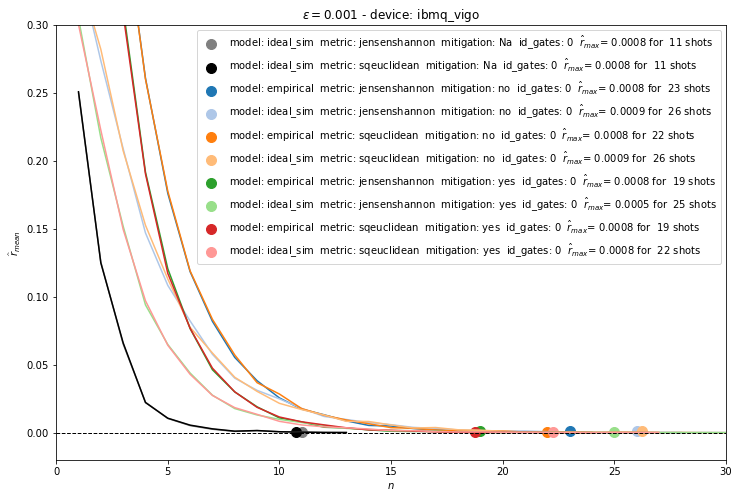

In [48]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors are the unsmoothed values 
opl.plot_curves(ideal_data_list + empirical_data_list,
                np.array(range(2+len(empirical_data_list))),
            "$\epsilon=0.001$" , ["device"],
            ["model","metric","mitigation","id_gates"],
            right_xlimit = 30, bottom_ylimit = -0.02, top_ylimit = 0.3)

In [49]:
import winsound
duration = 2000  # milliseconds 
freq = 800  # Hz
winsound.Beep(freq, duration)

In [50]:
import qiskit.tools.jupyter
%qiskit_version_table